In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import reduce_by_labels

from brainstat.datasets import fetch_parcellation, fetch_template_surface
from brainstat.context.genetics import surface_genetic_expression

import pyls

/home/rhaast/venv/brainstat/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/project/6050199/rhaast/04_Resources/brainstat_data'

# Load surfaces and parcellation used for calculation of gradients
glasser_360_fs5  = fetch_parcellation("fsaverage5", "glasser", 360, data_dir=data_dir)
surfaces         = fetch_template_surface("fsaverage5", join=False, data_dir=data_dir)
surf_lh, surf_rh = load_fsa5()

# Extract expression data
# expression      = surface_genetic_expression(glasser_360_fs5, surfaces, space="fsaverage", data_dir=data_dir)

# Or load pre-extracted
expression = pd.read_pickle('glasser_360_fs5_abagen.pkl')

# Load list of brain genes and cell type info
genes_cell_types = pd.read_csv('genes_cell_types.csv')

In [3]:
# with open('all_genes.txt', 'a') as out_file:
#     for gene in expression.columns:
#         out_file.write("%s\n" % gene)

### rs-fMRI data

In [85]:
data_used = 'dmri'

if data_used == 'rfmri':
    g_l = nib.load('HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_Gradient-1_weighted_L_fsa-10k.gii').darrays[0].data
    g_r = nib.load('HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_Gradient-1_weighted_R_fsa-10k.gii').darrays[0].data
elif data_used == 'dmri':
    g_l = nib.load('HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Gradient-1_weighted_L_fsa-10k.gii').darrays[0].data
    g_r = nib.load('HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/Diff_7Tsubj7TDWI_Gradient-1_weighted_R_fsa-10k.gii').darrays[0].data   
g      = np.hstack((g_l, g_r))
g_rois = reduce_by_labels(g, glasser_360_fs5)

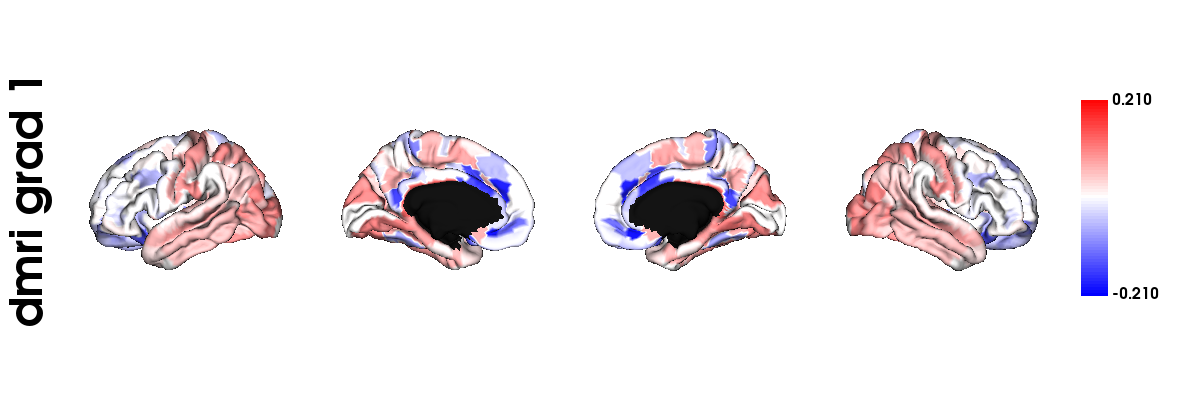

In [86]:
plot_hemispheres(surf_lh, surf_rh, array_name=g, size=(1200, 400), cmap='bwr', color_range='sym',
                 color_bar=True, label_text=[f'{data_used} grad 1'], interactive=False, transparent_bg=False, embed_nb=True)

In [87]:
# Select top 10% and bottom 10% only
percentile_lowest = np.nanpercentile(g_rois, 10)
lowest = np.where(g_rois[1:]<percentile_lowest, 1, 0)

percentile_highest = np.nanpercentile(g_rois, 90)
highest = np.where(g_rois[1:]>percentile_highest, 1, 0)

In [88]:
# Stack lowest and highest ROIs
expression_low     = expression.values[lowest==1,:]
expression_high    = expression.values[highest==1,:]

expression_stacked = np.vstack((
    expression_low[~np.isnan(np.sum(expression_low,axis=1))],
    expression_high[~np.isnan(np.sum(expression_high,axis=1))]
))

In [89]:
# Set up groups for PLS
groups = [np.sum(~np.isnan(np.sum(expression_low,axis=1))), np.sum(~np.isnan(np.sum(expression_high,axis=1)))]
groups

[30, 32]

In [90]:
# Run PLS
pls = pyls.meancentered_pls(expression_stacked, groups=groups, mean_centering=1)

In [91]:
# Get normalized gene weights, i.e., bootstrapped ratios 
bsr = pls['bootres']['x_weights_normed'][:,0]

In [92]:
# Define reliable genes (i.e., p_boot < .01 / -2.58 < BSR > 2.58)
pls_plus = expression.columns[bsr>2.58]
pls_min  = expression.columns[bsr<-2.58]

In [93]:
# Filtere list of brain genes and cell types for PLS genes 
cell_types_plus = genes_cell_types[np.isin(genes_cell_types.gene,pls_plus)]
cell_types_min  = genes_cell_types[np.isin(genes_cell_types.gene,pls_min)]

In [94]:
# Calculate enrichment ratio
unique_plus, counts_plus = np.unique(cell_types_plus['class'],return_counts=True)
unique_min, counts_min   = np.unique(cell_types_min['class'],return_counts=True)

er_plus = [ x/len(pls_plus) for x in counts_plus ]
er_min  = [ x/len(pls_min) for x in counts_min ]

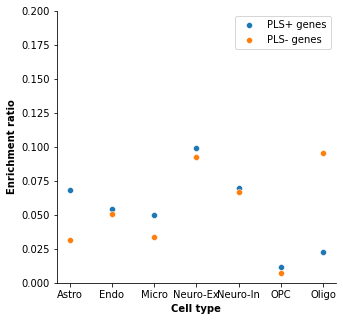

In [95]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.scatterplot(x=unique_plus, y=er_plus, label='PLS+ genes', ax=ax)
sns.scatterplot(x=unique_min, y=er_min, label='PLS- genes', ax=ax)

plt.xlabel('Cell type', weight='bold')
plt.ylabel('Enrichment ratio', weight='bold')

plt.ylim(0,0.2)

sns.despine()

plt.savefig(f'{data_used}_pls_gene-expression_vs_cell-types.png', bbox_inches='tight', transparent=False)
plt.show()

In [13]:
genes_sorting_lv = np.argsort(np.abs(pls['bootres']['x_weights_normed'][:,0]))
genes_sorted = list(expression.columns[genes_sorting_lv])

In [107]:
with open('GOlist.txt', 'a') as out_file:
    for gene in genes_sorted:
        out_file.write("%s\n" % gene)

In [137]:
with open('high_genes.txt', 'a') as out_file:
    for gene in expression.columns[bsr>2.58]:
        out_file.write("%s\n" % gene)

In [135]:
with open('low_genes.txt', 'a') as out_file:
    for gene in expression.columns[bsr<-2.58]:
        out_file.write("%s\n" % gene)